# homework 10: the adventure of the moonlighting genes
* Eric Yang
* 11/14/20

Goal: predict gene battery relationtionships from Adler's RNA-seq data with NMF

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read in Adler's RNA-seq data, column name is cell number
data = pd.read_csv('w10-data.tbl', delim_whitespace=True, index_col=0, names=range(60))

In [3]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
anise,1453,11100,4600,6130,8434,9249,2232,10746,4745,2764,...,2859,715,10075,1816,196,3506,3454,3576,6269,835
apricot,944,14,1591,142,372,568,1374,154,582,651,...,375,1257,217,300,2250,460,578,415,1330,1387
artichoke,883,155,278,720,23,175,15,206,560,937,...,922,395,122,557,465,400,512,825,27,609
arugula,228,35,69,158,9,44,2,48,115,231,...,198,94,44,135,105,84,114,167,3,134
asparagus,608,5,1065,89,262,409,859,87,357,399,...,257,791,156,199,1429,261,354,255,849,887


## 1. write a script that simulates positive control data

In [4]:
def gen_data(N=100,M=60,R=3,C=100000,ML=2):
    '''
    N is the number of genes
    M is the number of samples(cells)
    R os the number of modules
    C is the "expected" number of reads per sample
    ML is the number of moonlighting genes
    generates and returns expected read counts given weights and mixture coefficient parameters
    '''
    # gene-module matrix
    W = np.zeros((N,R))
    # randomly choose which genes are moonlighting
    ML_genes = np.random.choice(range(0,N),size=ML,replace=False)
    # assign genes to modules
    for idx, gene in enumerate(W):
        if idx in ML_genes:
            mod = np.random.choice(range(0,R),size=2,replace=False)
            gene[mod[0]] = 1
            gene[mod[1]] = 1
        else:
            mod = np.random.choice(range(0,R),size=1)
            gene[mod] = 1
    # normalize so each module sums to 1
    W = W/np.sum(W,axis=0)
    
    # module-cell matrix
    H = np.ones((R,M))
    for cell in range(M):
        H[:,cell] = np.random.dirichlet(H[:,cell])
    
    # calculate lambda, expected counts
    C_total = np.array([C]*M)
    lamb = (W@H) * C_total
    # incorporate poisson noise
    V = np.random.poisson(lamb)
    
    return V,W,H

In [5]:
def log_likelihood(V,W,H):
    '''
    Given W(gene-module probability matrix) and H (module-cell probability matrix), 
    return log likelihood of V (read counts matrix) based on Poisson noise, 
    calculated without constant log(V!) term
    '''
    # calculate lambda, expected counts
    C_total = np.sum(V,axis=0)
    lamb = (W@H) * C_total
    # calculate LL
    ll = np.sum(V*np.log(lamb)-lamb)
    return ll

Note that in the log likelihood calculations, the constant factorial term is ignored since it is uniform within one condition. Therefore, the true vs random comparisons in part 1 and the number of modules vs log likelihood plots in parts 2 and 3 are still valid with an uniform likelihood offset. We just need to pay attention to the differences rather than the raw values.

In [6]:
# generate synthetic data
np.random.seed(5)
V,W,H = gen_data(N=100,M=60,R=3,C=100000,ML=2)

# calculate log likelihood of sythetic data given true parameters
print("log likelihood of V given true W,H:",log_likelihood(V,W,H))

log likelihood of V given true W,H: 37150489.39926867


In [7]:
# calculate log likelihood of sythetic data given random parameters
W_rand = np.ones((100,3))
for cell in range(3):
    W_rand[:,cell] = np.random.dirichlet(W_rand[:,cell])
H_rand = np.ones((3,60))
for cell in range(60):
    H_rand[:,cell] = np.random.dirichlet(H_rand[:,cell])
print("log likelihood of V given random W,H:",log_likelihood(V,W_rand,H_rand))

log likelihood of V given random W,H: 34168874.53002933


As expected, the log likelihood of the synthetic data(V) given the true parameters (W,H) is much higher than the data given random parameters. Let's generate more synthetic data (V2) with more underlying modules.

In [8]:
# generate more synthetic data, increase R
np.random.seed(5)
V2,W2,H2 = gen_data(N=100,M=60,R=5,C=100000,ML=2)
# random W and H
W_rand = np.ones((100,5))
for cell in range(5):
    W_rand[:,cell] = np.random.dirichlet(W_rand[:,cell])
H_rand = np.ones((5,60))
for cell in range(60):
    H_rand[:,cell] = np.random.dirichlet(H_rand[:,cell])
print("log likelihood of V2 given true W2,H2:",log_likelihood(V2,W2,H2))
print("log likelihood of V2 given random W,H:", log_likelihood(V2,W_rand,H_rand))

log likelihood of V2 given true W2,H2: 37410645.74309559
log likelihood of V2 given random W,H: 34171131.66354009


As expected, the log likelihood of the synthetic data with more underlying modules(V2) given the true parameters (W2,H2) is still much higher than the data given random parameters. Let's generate a final set of synthetic data (V3) with more moonlighting genes.

In [9]:
# generate more synthetic data, increase number ML
np.random.seed(5)
V3,W3,H3 = gen_data(N=100,M=60,R=3,C=100000,ML=5)
# random W and H
W_rand = np.ones((100,3))
for cell in range(3):
    W_rand[:,cell] = np.random.dirichlet(W_rand[:,cell])
H_rand = np.ones((3,60))
for cell in range(60):
    H_rand[:,cell] = np.random.dirichlet(H_rand[:,cell])
print("log likelihood of V3 given true W3,H3:",log_likelihood(V3,W3,H3))
print("log likelihood of V3 given random W,H:", log_likelihood(V3,W_rand,H_rand))

log likelihood of V3 given true W3,H3: 36945422.64927184
log likelihood of V3 given random W,H: 34104317.37123056


As expected, the log likelihood of the synthetic data with more moonlighting genes(V3) given the true parameters (W3,H3) is still much higher than the data given random parameters. Comparing the log likelihoods, the gen_data and log_likelihood functions are working as expected.

## 2. implement nonnegative matrix factorization

In [10]:
def nmf(V,R,thresh=0.0001):
    '''
    R is the number of intermediate modules to decompose V  (read counts matrix, NxM) into:
    W (gene-module probability matrix, NxR) 
    and H (module-cell probability matrix, RxM), all values in W and H are nonnegative
    Thresh is used to assess log likelihood convergence
    '''
    # randomly initialize W and H 
    N = np.shape(V)[0]
    M = np.shape(V)[1]
    W = np.ones((N,R))
    H = np.ones((R,M))
    # normalize W and H
    for mod in range(R):
        W[:,mod] = np.random.dirichlet(W[:,mod])
    for cell in range(M):
        H[:,cell] = np.random.dirichlet(H[:,cell])
    
    LL = 0
    old_LL = float("inf")
    while abs(old_LL - LL) > thresh:
        # update old_LL
        old_LL = LL
        
        # calculate lambda
        C_total = np.sum(V,axis=0)
        lamb = (W@H) * C_total
        
        # calculate log likelihood
        LL = log_likelihood(V,W,H)
        
        # update W and H
        W *= (V*C_total/lamb) @ H.T
        W /= np.sum(W,axis=0)
        H *= ((V.T/lamb.T) @ W).T
    
    # Given W matrix, predict gene-module relationships
    # make W sparse to assign gene-module predictions with a probability cutoff determined empirically
    for i in range(N):
        for j in range(R):
            if W[i][j] < 0.0034: # throw out noise, most likely noise, this cutoff gave best result for synth data
                W[i][j] = 0
    W /= np.sum(W,axis=0)
        
    return W,H,LL

In our nmf method above, there is a cutoff probability that is used to remove noise (very low relative expression levels) from the final gene-module W matrix. This was done to remove ambiguity when predicting gene-module relationships. The specific value for this cutoff was trained with the multiple synthetic datasets with varied parameters demonstrated below. The final cutoff value of 0.0034 gave perfect predictions of gene-module relationships and moonlighting genes for the synthetic training data. I will explore the nuances of this value further in part 3

Knowing the true batteries and moonlighting genes, let's see how well our nmf model predicts these values given gene-cell matrix (V). The true R here is 3.

In [11]:
# simulate different guesses of modules 1-6, might take awhile to run
LLs = []
for i in range(1,7):
    np.random.seed(5)
    W_pred,H_pred,LL = nmf(V,i)
    LLs.append(LL)

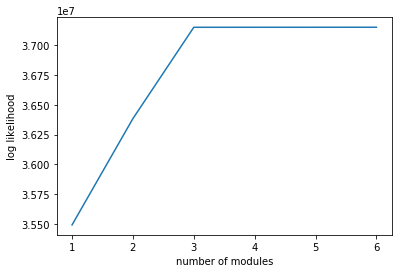

In [12]:
# plot R vs LL
plt.plot(range(1,7),LLs)
plt.xlabel('number of modules')
plt.ylabel('log likelihood')
plt.show()

The module-likelihood elbow curve above gives us an idea on how much power is "gained" as we increase the complexity of our model, which is the number of modules R in this case. We see that there is not much power gained as R increases past 3, suggesting that we may overfit the model if we select larger number of modules without gaining much power. While a more robust Bayesian marginalization method can decisively help us conclude the best R to fit our data, selecting the elbow of the curve gives us a reliable enough prediction of R for this problem.

In [13]:
# go with R = 3
np.random.seed(5)
W_pred,H_pred,LL = nmf(V,3)

In [14]:
def make_battery(W):
    '''
    Given W (gene-module probability matrix, NxR), create a set of R lists, where each list
    includes gene indexes for genes that are influenced by the same module
    '''
    R = np.shape(W)[1]
    battery = []
    for mod in range(R):
        genes = []
        for idx, gene in enumerate(W):
            if gene[mod] > 0:
                genes.append(idx)
        battery.append(sorted(genes))
    return battery

In [15]:
# check that the predicted gene-module assignments are same as the real assignments
pred_battery = make_battery(W_pred)
actual_battery = make_battery(W)
for i in range(np.shape(pred_battery)[0]):
    assert pred_battery[i] in actual_battery

In [16]:
def moonlight(battery):
    '''
    Given gene-module assignments, where each list contains gene indexes for genes that are influenced by the same module
    return gene indexes of genes that show up across multiple modules, which are moonlighting genes
    '''
    ML = set()
    exist = set()
    for i in battery:
        for j in i:
            if j in exist:
                ML.add(j)
            else:
                exist.add(j)
    return sorted(ML)

In [17]:
# check moonlighting genes
assert moonlight(pred_battery) == moonlight(actual_battery)

Our nmf model perfectly predicts our batteries and moonlighting genes given V compared to the true W and H. Let's check how well we predict on the V2 dataset, where the true R is increased to 5, and the true number of moonlight genes is 2.

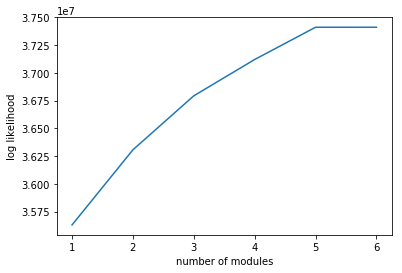

In [18]:
# simulate different guesses of modules 1-6, might take awhile to run
LLs = []
for i in range(1,7):
    np.random.seed(5)
    W_pred,H_pred,LL = nmf(V2,i)
    LLs.append(LL)
    
# plot R vs LL
plt.plot(range(1,7),LLs)
plt.xlabel('number of modules')
plt.ylabel('log likelihood')
plt.show()

In [19]:
# go with R = 5
np.random.seed(5)
W_pred,H_pred,LL = nmf(V2,5)

# check that the predicted gene-module assignments are same as the real assignments
pred_battery = make_battery(W_pred)
actual_battery = make_battery(W2)

for i in range(np.shape(pred_battery)[0]):
      assert pred_battery[i] in actual_battery


# check moonlighting genes
assert moonlight(pred_battery) == moonlight(actual_battery)

Again, our nmf model perfectly predicts our batteries and moonlighting genes given V2 compared to the true W2 and H2. Let's check how well we predict on the V3 dataset, where the true R is 3, and the true number of moonlight genes is increased to 5.

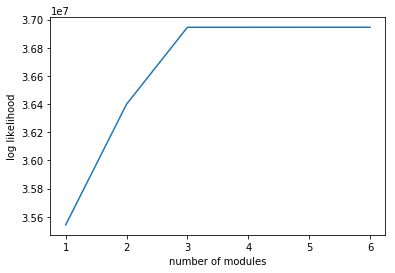

In [20]:
# simulate different guesses of modules 1-6, might take awhile to run
LLs = []
for i in range(1,7):
    np.random.seed(5)
    W_pred,H_pred,LL = nmf(V3,i)
    LLs.append(LL)
    
# plot R vs LL
plt.plot(range(1,7),LLs)
plt.xlabel('number of modules')
plt.ylabel('log likelihood')
plt.show()

In [21]:
# go with R = 3
np.random.seed(5)
W_pred,H_pred,LL = nmf(V3,3)

# check that the predicted gene-module assignments are same as the real assignments
pred_battery = make_battery(W_pred)
actual_battery = make_battery(W3)

for i in range(np.shape(pred_battery)[0]):
     assert pred_battery[i] in actual_battery

# check moonlighting genes
assert moonlight(pred_battery) == moonlight(actual_battery)

Again, our nmf model perfectly predicts our batteries and moonlighting genes given V3 compared to the true W3 and H3. With these training datasets, our nmf model with the selected cutoff hyperparameter predicts the batteries and moonlighting genes well. A more robust training with separate train and validation datasets on the nmf model may help us tune the cutoff hyperparameter better to prevent overfitting and lower model variance. I also tried different random initializations to get closer to the global optima and other V-W-H matrices with different parameters to test model variance. They are not shown here due to time complexity, but I achieved a high accuracy on all these trials as well. More robust hyperparameter tuning and more efficient implementation to lower runtime are both areas of improvement for the future.

## 3. analyze the Adler data

Let's predict the batteries and the moonlighting genes given Adler's RNA-seq data using our nmf model.

In [22]:
gene_names = data.index # save gene names
adler_V = np.array(data.values.tolist()) # turn df into 2D np array

In [23]:
# simulate different guesses of modules 3-6, might take awhile to run
adler_LLs = []
for i in range(3,7):
    np.random.seed(22)
    adler_W,adler_H,LL = nmf(adler_V,i)
    adler_LLs.append(LL)

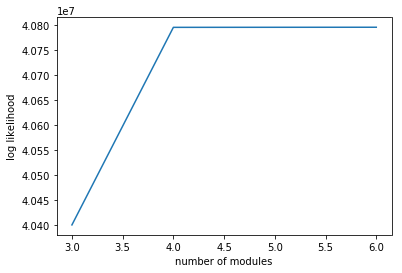

In [24]:
# plot R vs LL
plt.plot(range(3,7),adler_LLs)
plt.xlabel('number of modules')
plt.ylabel('log likelihood')
plt.show()

Given the elbow curve, I predict that there are 4 gene batteries. See elbow curve interpretation in part 2 for detailed explanation.

In [25]:
# go with R = 4
np.random.seed(6)
adler_W,adler_H,LL = nmf(adler_V,4)

In [26]:
adler_battery = make_battery(adler_W)
print("Here are the predicted total number of genes and the predicted gene names in each battery:") 
for i, battery in enumerate(adler_battery):
    print("battery", i+1, "(", len(battery), "genes): ", np.array(gene_names)[battery])
    print("")

Here are the predicted total number of genes and the predicted gene names in each battery:
battery 1 ( 18 genes):  ['anise' 'cantaloupe' 'cranberry' 'grape' 'kohlrabi' 'leek' 'lentil'
 'melon' 'orange' 'papaya' 'parsley' 'pepper' 'plantain' 'pomegranate'
 'scallion' 'watermelon' 'yam' 'zucchini']

battery 2 ( 37 genes):  ['artichoke' 'avocado' 'banana' 'beet' 'blackberry' 'broccoli' 'caraway'
 'chard' 'cucumber' 'elderberry' 'ginger' 'grapefruit' 'guava' 'honeydew'
 'horseradish' 'juniper' 'kiwi' 'lime' 'maize' 'mustard' 'okra' 'parsnip'
 'peach' 'pineapple' 'potato' 'quince' 'raisin' 'raspberry' 'rosemary'
 'rutabaga' 'sage' 'spinach' 'strawberry' 'thyme' 'tomato' 'wasabi'
 'watercress']

battery 3 ( 19 genes):  ['basil' 'butternut' 'cabbage' 'celery' 'chard' 'cherry' 'fennel' 'garlic'
 'huckleberry' 'mulberry' 'mushroom' 'nectarine' 'olive' 'pear' 'plum'
 'pumpkin' 'raspberry' 'rhubarb' 'tangerine']

battery 4 ( 20 genes):  ['apricot' 'asparagus' 'blueberry' 'carrot' 'cauliflower' 'c

In [27]:
ML_index = list(moonlight(adler_battery))
print("Predicted Adler's moonlighting genes: ", np.array(gene_names)[ML_index])

Predicted Adler's moonlighting genes:  ['chard' 'grape' 'kohlrabi' 'pepper' 'raspberry']


The gene battery and moonlighting genes predictions from my model are shown above. I noticed that there are genes given in the dataset not placed in any batteries. Let's explore this further.

In [28]:
# find genes not in any battery, these genes have a row of zeros in W matrix
zero_idx = []
for idx, gene in enumerate(adler_W):
    if sum(gene) == 0:
        zero_idx.append(idx)
data.iloc[zero_idx]

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
arugula,228,35,69,158,9,44,2,48,115,231,...,198,94,44,135,105,84,114,167,3,134
chestnut,1,20,14,6,23,16,4,20,13,7,...,6,1,22,4,0,9,8,6,5,0
cilantro,158,20,33,134,2,33,5,39,101,144,...,165,86,27,90,82,73,86,152,7,112
currant,119,23,43,77,4,17,4,29,67,134,...,116,39,27,69,55,49,61,117,5,75
eggplant,187,32,61,140,7,35,5,32,121,198,...,170,69,31,107,94,67,99,183,4,117
fig,16,158,81,99,139,145,30,166,82,55,...,41,9,177,32,2,52,61,54,98,11
gooseberry,55,8,16,42,2,8,1,6,21,51,...,40,21,2,30,21,19,40,28,2,24
lettuce,14,3,8,11,0,1,0,4,10,17,...,18,8,4,16,12,9,10,16,1,15
oregano,27,6,4,23,0,4,0,4,8,24,...,22,7,2,11,8,12,20,27,0,18
radish,10,30,17,23,90,20,131,45,43,4,...,6,85,27,62,18,86,85,51,66,59


It looks like all the genes that are not placed in batteries all have low read counts (<250 for all cells). They were all determined as noise by our cutoff hyperparameter when predicting the gene-module matrix W. A large cutoff value tends to exclude more genes in battery prediction, while a lower cutoff value would be able to place more genes in batteries but also predict many more moonlighting genes. This highlights the importance of cutoff hyperparameter tuning with varied synthetic training data to differentiate signal from noise. In machine learning, since we usually select  hyperparameters based on training/validation data, there is always a possibility that we overfit the model, which can lead to some prediction error in predicting Adler's test data here. Training our model on more dataset with varied parameters, selecting hyperparameters based on battery-moonlighting (sensitivity-specificity) tradeoffs, acquiring more data for genes with lower read counts, and implementing regression techniques to prevent overfitting are all possible avenues to improve our nmf model's prediction accuracy.